## German credit data

In [123]:
include("../src/load.jl")
using AlgorithmicRecourse
using CSV;
using DataFrames;
using LinearAlgebra;

In [124]:
df = CSV.read("../data/credit.csv", DataFrame);
df[!,:] = convert.(Float64, df[!,:]); # convert to floats
y = df[:,:y]
N = length(y)
X = Matrix(df[:,Not(:y)])';
X_train = copy(X)
y_train = copy(y);


In [125]:
using MLDataUtils, Random, Flux
Random.seed!(1234)

# # Preproc:
# X_train, y_train = oversample((X_train,y_train))
# # Standardize continuous features:
# using StatsBase
# dt = fit(ZScoreTransform, X_train[1:3,:], dims=1)
# X_train[1:3,:] = StatsBase.transform(dt, X_train[1:3,:])

# Stack:
xs = Flux.unstack(X_train,2)
ys = Flux.flatten(y_train)
data = zip(xs, ys)
nn = Models.build_model(input_dim=size(X_train)[1], n_hidden=32)
loss(x, y) = Flux.Losses.logitbinarycrossentropy(nn(x), y)
ps = params(nn);

┌ Info: Saved animation to 
│   fn = /var/folders/99/2fj_h1qs3gj3x8nqmpx20mrc0000gq/T/jl_JqaQBY.gif
└ @ Plots /Users/FA31DU/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/var/folders/99/2fj_h1qs3gj3x8nqmpx20mrc0000gq/T/jl_JqaQBY.gif")
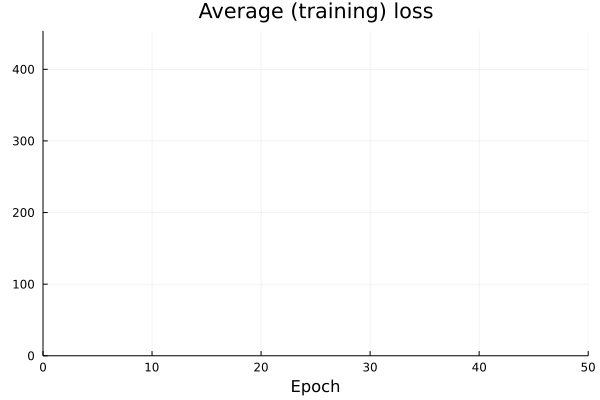

In [126]:
using Flux.Optimise: update!, ADAM
using Statistics
opt = ADAM()
epochs = 50
avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))

using Plots
anim = Animation()
plt = plot(ylim=(0,avg_loss(data)), xlim=(0,epochs), legend=false, xlab="Epoch")
avg_l = []

for epoch = 1:epochs
  for d in data
    gs = gradient(params(nn)) do
      l = loss(d...)
    end
    update!(opt, params(nn), gs)
  end
  avg_l = vcat(avg_l,avg_loss(data))
  plot!(plt, avg_l, color=1, title="Average (training) loss")
  frame(anim, plt)
end

gif(anim)

**EVEN THE NEURAL NET JUST CLASSIFIES ALL AS 1, WHAT IS GOING ON HERE?**

In [128]:
sum(round.(Flux.σ.(nn(X_train)))' .== 1)

1000

┌ Warning: The closest lower feasible false positive rate to some of the required values (0.0033444816053511705, 0.006688963210702341, 0.010033444816053512, 0.013377926421404682, 0.016722408026755852, 0.020066889632107024, 0.023411371237458192, 0.026755852842809364, 0.030100334448160536, 0.033444816053511704, 0.03678929765886288, 0.04013377926421405, 0.043478260869565216, 0.046822742474916385, 0.05016722408026756, 0.05351170568561873, 0.056856187290969896, 0.06020066889632107, 0.06354515050167224, 0.06688963210702341, 0.07023411371237458, 0.07357859531772576, 0.07692307692307693, 0.0802675585284281, 0.08361204013377926, 0.08695652173913043, 0.0903010033444816, 0.09364548494983277, 0.09698996655518395, 0.10033444816053512, 0.10367892976588629, 0.10702341137123746, 0.11036789297658862, 0.11371237458193979, 0.11705685618729098, 0.12040133779264214, 0.12374581939799331, 0.12709030100334448, 0.13043478260869565, 0.13377926421404682, 0.13712374581939799, 0.14046822742474915, 0.14381270903010

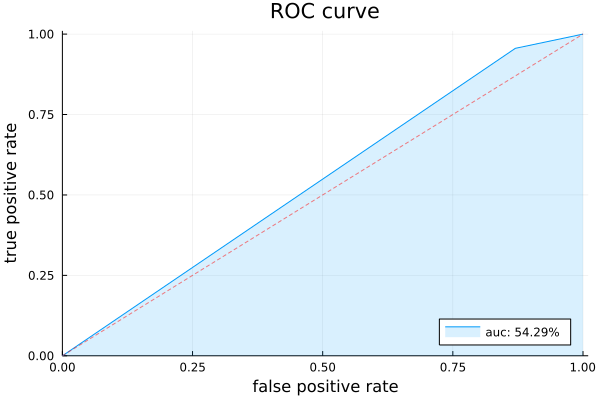

In [5]:
using EvalMetrics
using Plots
y_hat = predict(model,X)
rocplot(y,y_hat)

In [6]:
generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.01,), schut=(T=1000,δ=0.05));
target = 1;

In [7]:
props = [0.01,0.05,0.1,0.25]
results = DataFrame()
for prop in props
    results_prop = run_experiment(X,y,bayes_logreg,target,generators,generator_args,experiment_dynamic)
    insertcols!(results_prop, :prop => prop)
    results = vcat(results, results_prop)
end

Possible that these results are driven by the following fact:

- classifier is biased towards target class (try random over/undersampling)

In [11]:
dt_plot = groupby(results, [:period, :generator, :prop]) |>
    gdf -> combine(gdf, :validity .=> [mean, std] .=> [:mean, :std])
dt_plot[!,:ymin] = dt_plot[!,:mean] - dt_plot[!,:std]
dt_plot[!,:ymax] = dt_plot[!,:mean] + dt_plot[!,:std]
ggplot(data=dt_plot, aes(x=:period, y=:mean, colour=:generator)) +
    geom_line() + 
    geom_errorbar(aes(ymin=:ymin, ymax=:ymax), width=.2) + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() |>
    p -> ggsave("www/german_dynamic_validity.png", plot = p);
load("www/german_dynamic_validity.png")

┌ Warning: RCall.jl: Saving 7 x 7 in image
└ @ RCall /Users/FA31DU/.julia/packages/RCall/iMDW2/src/io.jl:160


LoadError: UndefVarError: load not defined

Interesting to see that there are some clear trends in the cost of recourse over time:

- what could be the reason for these dynamics?

In [ ]:
dt_plot = groupby(results, [:period, :generator, :prop]) |>
    gdf -> combine(gdf, :cost .=> [mean, std] .=> [:mean, :std])
dt_plot[!,:ymin] = dt_plot[!,:mean] - dt_plot[!,:std]
dt_plot[!,:ymax] = dt_plot[!,:mean] + dt_plot[!,:std]
ggplot(data=dt_plot, aes(x=:period, y=:mean, colour=:generator)) +
    geom_line() + 
    geom_errorbar(aes(ymin=:ymin, ymax=:ymax), width=.2) + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() |>
    p -> ggsave("www/german_dynamic_cost.png", plot = p);
load("www/german_dynamic_cost.png")

### Adjusting for imbalance

In [ ]:
using MLDataUtils
X_train, y_train = oversample((transpose(X),y))
X_train = transpose(X_train);
model = bayes_logreg(X_train,y_train);

In [ ]:
y_hat = predict(model,X)
rocplot(y,y_hat)